In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from cryptovision.tools import (
    image_directory_to_pandas,
    split_image_dataframe,
    tf_dataset_from_pandas,
    CryptoVisionAI
)

from tensorflow.keras.applications import ResNet50V2, EfficientNetV2B0                                          # type: ignore
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess                       # type: ignore
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess           # type: ignore
from tensorflow.keras.layers import (                                                                           # type: ignore    
    Input, RandomFlip, RandomRotation, RandomZoom, 
    RandomTranslation, RandomContrast, RandomBrightness,
    GlobalAveragePooling2D, Dense, BatchNormalization, Activation,
    Concatenate, Dropout, LeakyReLU
) 

from cryptovision.model import *

# Enable mixed precision for Apple Silicon
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-01-13 09:32:20.385 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [2]:
# Dataset
SETUP = {
    "class_samples_threshold": 99,
    "test_size": .15,
    "validation_size": .15,
    "batch_size": 128,
    
    # Training
    "image_shape": (128, 128, 3),
    "epochs": 5,
    "learning_rate": 1e-4,
    "loss_type": {
        "family": "categorical_focal_crossentropy",
        "genus": "categorical_focal_crossentropy",
        "species": "categorical_focal_crossentropy",
    },
    "metrics": {
        "family": ["accuracy", "AUC", "Precision", "Recall"],
        "genus": ["accuracy", "AUC", "Precision", "Recall"],
        "species": ["accuracy", "AUC", "Precision", "Recall"],
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 5,
        "restore_best_weights": True
    },
    "reduce_lr": {
        "monitor": "val_loss",
        "lr_factor": 0.5,
        "lr_patience": 3,
        "lr_min": 1e-6
    }
    
}


In [3]:
df_lab = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/Species_v03")
df_web = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/web/Species_v01")
df_inatlist = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/inaturalist/Species_v02")

df = pd.concat([df_lab, df_web, df_inatlist], ignore_index=True, axis=0)

# find in the species column the values with lass than 50 occurences
counts = df['species'].value_counts()
df = df[df['species'].isin(counts[counts > SETUP['class_samples_threshold']].index)]

train_df, val_df, test_df = split_image_dataframe(df, test_size=0.15, val_size=0.15, stratify_by='folder_label')

names = {
    'family': sorted(df['family'].unique()),
    'genus': sorted(df['genus'].unique()),
    'species': sorted(df['species'].unique()),
}

train_ds, _, _, _ = tf_dataset_from_pandas(train_df, batch_size=128, image_size=SETUP['image_shape'][:2])
val_ds, _, _, _ = tf_dataset_from_pandas(val_df, batch_size=128, image_size=SETUP['image_shape'][:2])
test_ds, _, _, _ = tf_dataset_from_pandas(test_df, batch_size=128, image_size=SETUP['image_shape'][:2])

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2025-01-13 09:32:22.120333: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-01-13 09:32:22.120364: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-01-13 09:32:22.120370: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-01-13 09:32:22.120387: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-13 09:32:22.120397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
efnet = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=SETUP['image_shape'])
efnet.trainable = False

resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=SETUP['image_shape'])
resnet.trainable = False

augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(height_factor=(0.05, 0.1), width_factor=(0.05, 0.1)),  # Wider zoom range
        RandomContrast(0.2),
        RandomBrightness(0.2),
        RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomCrop(SETUP['image_shape'][0], SETUP['image_shape'][1]),
        tf.keras.layers.GaussianNoise(0.1),
    ],
    name='augmentation'
)

In [6]:
SEED = 7

augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal", seed=SEED),
        RandomRotation(0.1),
        RandomZoom(height_factor=(0.05, 0.1), width_factor=(0.05, 0.1), seed=SEED),  # Wider zoom range
        RandomContrast(0.2, seed=SEED),
        RandomBrightness(0.2, seed=SEED),
        RandomTranslation(0.1, 0.1, seed=SEED),
        tf.keras.layers.RandomCrop(SETUP['image_shape'][0], SETUP['image_shape'][1], seed=SEED),
        tf.keras.layers.GaussianNoise(0.1, seed=SEED),
    ],
    name='augmentation'
)

In [7]:
def basic_model (name, labels, pretrain, preprocess, input_shape, augmentation=None):
    
    inputs = layers.Input(shape=input_shape, name='input_layer')
    x = augmentation(inputs) if augmentation else inputs
    x = preprocess(x)
    x = pretrain(x, training=False)
    
    # Feature Extracion from Pretrained Model
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    features = layers.Dropout(0.5)(x)
    
    #features = layers.GlobalAveragePooling2D(name='GlobAvgPool2D')(x)
    
    # Family Output
    family_output = layers.Dense(len(labels['family']), activation='softmax', name='family')(features)
    
    # Genus Output
    genus_output = layers.Dense(len(labels['genus']), activation='softmax', name='genus')(features)
    
    # Species Output
    species_output = layers.Dense(len(labels['species']), activation='softmax', name='species')(features)
    
    model = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)
    
    return model

model = basic_model(
    name="ResNet50V2",
    labels=names,
    pretrain=resnet,
    preprocess= resnet_preprocess,
    input_shape=SETUP['image_shape'],
    augmentation=augmentation
)

model.summary(show_trainable=True)

Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast_2 (Cast)     │ (None, 128,     │         0 │ input_layer[0… │   -   │
│                   │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ augmentation      │ (None, 128,     │         0 │ cast_2[0][0]   │   -   │
│ (Sequential)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ true_divide       │ (None, 128,     │         0 │ augmentation[… │   -   │
│ (TrueDivide)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ subtract          │ (None, 128,     │         0 │ true_divide[0… │   -   │
│ (Subtract)        │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resnet50v2        │ (None, 4, 4,    │ 23,564,8… │ subtract[0][0] │   N   │
│ (Functional)      │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ flatten (Flatten) │ (None, 32768)   │         0 │ resnet50v2[0]… │   -   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense (Dense)     │ (None, 512)     │ 16,777,7… │ flatten[0][0]  │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 512)     │         0 │ dense[0][0]    │   -   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ family (Dense)    │ (None, 18)      │     9,234 │ dropout[0][0]  │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ genus (Dense)     │ (None, 43)      │    22,059 │ dropout[0][0]  │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ species (Dense)   │ (None, 61)      │    31,293 │ dropout[0][0]  │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 40,405,114 (154.13 MB)

 Trainable params: 16,840,314 (64.24 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

2025-01-10 12:19:42.332884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 32 of 11722
2025-01-10 12:20:00.778888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-10 12:20:00.778909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1 of 1000
2025-01-10 12:20:00.778972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-10 12:20:01.341537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


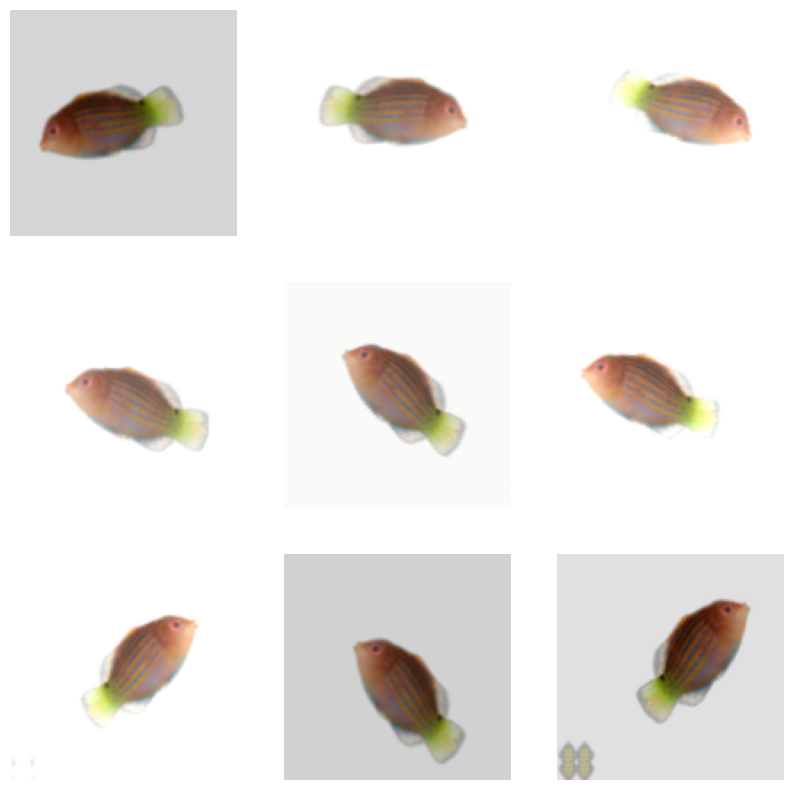

In [5]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("float32") / 255)
        plt.axis('off')

In [6]:
import wandb
from loguru import logger
from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")

PROJ = "CryptoVision - AI Development"
NICKNAME = f"cvis_CVFTUN_{SETUP['image_shape'][0]}_v101"


with wandb.init(project=PROJ, name=NICKNAME, config={**SETUP}) as run:
    
    model = shared_concat_model(
        name=NICKNAME,
        labels=names,
        pretrain=resnet,
        preprocess= resnet_preprocess,
        augmentation=None,
        input_shape=SETUP['image_shape'],
    )
    
    logger.info(print(model.summary(show_trainable=True)))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=SETUP["learning_rate"]),
        loss=SETUP['loss_type'],
        metrics=SETUP['metrics'],
        #loss_weights=SETUP["loss_weights"],
    )
    
    wandb_logger = WandbMetricsLogger()
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor=SETUP['early_stopping']["monitor"],
        patience=SETUP["early_stopping"]['patience'],
        restore_best_weights=SETUP['early_stopping']['restore_best_weights'],
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=SETUP['reduce_lr']["monitor"],
        factor=SETUP['reduce_lr']["lr_factor"],
        patience=SETUP['reduce_lr']["lr_patience"],
        min_lr=SETUP['reduce_lr']["lr_min"],
    )
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"models/{NICKNAME}.keras",
        monitor="val_loss", 
        save_best_only=True,  
        mode="min",  
        verbose=0  
    )
    
    history = model.fit(
        train_ds,
        epochs=SETUP["epochs"],
        validation_data=val_ds,
        callbacks=[wandb_logger, early_stopping, reduce_lr, checkpoint, TQDMProgressBar()],
        verbose=0,
    )
    
    logger.success(f"Model {NICKNAME} trained and logged to wandb.")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: leonardo-reginato (cryptovision). Use `wandb login --relogin` to force relogin


Model: "cvis_CVFTUN_384_v101"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 384,     │         0 │ -              │   -   │
│ (InputLayer)      │ 384, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ true_divide       │ (None, 384,     │         0 │ input_layer[0… │   -   │
│ (TrueDivide)      │ 384, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ subtract          │ (None, 384,     │         0 │ true_divide[0… │   -   │
│ (Subtract)        │ 384, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ fine_tuned_resne… │ (None, 12, 12,  │ 23,564,8… │ subtract[0][0] │   N   │
│ (Functional)      │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ GlobAvgPool2D     │ (None, 2048)    │         0 │ fine_tuned_re… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ shared_layer      │ (None, 2048)    │ 4,196,352 │ GlobAvgPool2D… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 2048)    │     8,192 │ shared_layer[… │   Y   │
│ (BatchNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 2048)    │         0 │ batch_normali… │   -   │
│ (Activation)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 2048)    │         0 │ activation[0]… │   -   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ family (Dense)    │ (None, 18)      │    36,882 │ dropout[0][0]  │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate       │ (None, 2066)    │         0 │ dropout[0][0], │   -   │
│ (Concatenate)     │                 │           │ family[0][0]   │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ genus (Dense)     │ (None, 43)      │    88,881 │ concatenate[0… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_1     │ (None, 2109)    │         0 │ dropout[0][0], │   -   │
│ (Concatenate)     │                 │           │ family[0][0],  │       │
│                   │                 │           │ genus[0][0]    │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ species (Dense)   │ (None, 61)      │   128,710 │ concatenate_1… │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 28,023,817 (106.90 MB)

 Trainable params: 4,454,921 (16.99 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

None
2025-01-09 18:22:09.451 | INFO     | __main__:<module>:22 - None


Epoch 1/5:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-09 18:22:11.574995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-09 18:22:24.410313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 27 of 11722
2025-01-09 18:22:34.634228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 55 of 11722
2025-01-09 18:22:44.720925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 84 of 11722
2025-01-09 18:22:47.277960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-09 18:22:47.279528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/5: 100%|██████████| 92/92 [03:59<00:00,  2.61s/batch, loss=0

2025-01-09 18:26:09.403 | INFO     | cryptovision.model:on_epoch_end:88 - Epoch 1 completed - Loss: 0.9950, Val Family Accuracy: 0.8945, Val Genus Accuracy: 0.8711, Val Species Accuracy: 0.8321


Epoch 2/5: 100%|██████████| 92/92 [16:02<00:00, 10.46s/batch, loss=0.1984, family_acc=0.9162, genus_acc=0.9016, species_acc=0.8680]


2025-01-09 18:42:11.636 | INFO     | cryptovision.model:on_epoch_end:88 - Epoch 2 completed - Loss: 0.1984, Val Family Accuracy: 0.9248, Val Genus Accuracy: 0.9117, Val Species Accuracy: 0.8882


Epoch 3/5: 100%|██████████| 92/92 [03:33<00:00,  2.32s/batch, loss=0.1132, family_acc=0.9434, genus_acc=0.9398, species_acc=0.9189]


2025-01-09 18:45:44.793 | INFO     | cryptovision.model:on_epoch_end:88 - Epoch 3 completed - Loss: 0.1132, Val Family Accuracy: 0.9359, Val Genus Accuracy: 0.9260, Val Species Accuracy: 0.9065


Epoch 4/5: 100%|██████████| 92/92 [03:30<00:00,  2.29s/batch, loss=0.0743, family_acc=0.9569, genus_acc=0.9565, species_acc=0.9427]


2025-01-09 18:49:15.564 | INFO     | cryptovision.model:on_epoch_end:88 - Epoch 4 completed - Loss: 0.0743, Val Family Accuracy: 0.9427, Val Genus Accuracy: 0.9324, Val Species Accuracy: 0.9168


Epoch 5/5: 100%|██████████| 92/92 [03:25<00:00,  2.24s/batch, loss=0.0498, family_acc=0.9707, genus_acc=0.9686, species_acc=0.9602]


2025-01-09 18:52:41.254 | INFO     | cryptovision.model:on_epoch_end:88 - Epoch 5 completed - Loss: 0.0498, Val Family Accuracy: 0.9443, Val Genus Accuracy: 0.9335, Val Species Accuracy: 0.9188
2025-01-09 18:52:41.392 | SUCCESS  | __main__:<module>:62 - Model cvis_CVFTUN_384_v101 trained and logged to wandb.


epoch/epoch,▁▃▅▆█
epoch/family_AUC,▁████
epoch/family_Precision,▁▆▇██
epoch/family_Recall,▁▆▇██
epoch/family_accuracy,▁▇▇██
epoch/family_loss,█▂▁▁▁
epoch/genus_AUC,▁████
epoch/genus_Precision,▁▅▇▇█
epoch/genus_Recall,▁▆▇██
epoch/genus_accuracy,▁▇▇██
epoch/genus_loss,█▂▁▁▁


In [5]:
import wandb
from loguru import logger
from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")

PROJ = "CryptoVision - Architecture Testing"
CV_PRETRAIN = "/Users/leonardo/Documents/Projects/cryptovision/models/cvis_efv2b0_128_spaat_shrd_conc_v25.110.1140.keras"
NICKNAME = f"cvis_ftun_efv2b0_128_spaat_shrd_conc_v25.110.1140"
SETUP['ftun_learning_rate'] = 1e-5
SETUP['ftun_epochs'] = 10


with wandb.init(project=PROJ, name=NICKNAME, config={**SETUP}) as run:
    
    model = tf.keras.models.load_model(CV_PRETRAIN)
    
    efb0 = model.get_layer('efficientnetv2-b0')

    # Unfreezing
    efb0.trainable = True
    set_trainable = False

    for layer in efb0.layers:
        if layer.name == 'block6d_se_excite':
            set_trainable = True
        if set_trainable:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = True
            else:
                layer.trainable = False
        else:
            layer.trainable = False
    
    logger.info(print(model.summary(show_trainable=True)))
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=SETUP["ftun_learning_rate"]),
        loss=SETUP['loss_type'],
        metrics=SETUP['metrics'],
    )
    
    wandb_logger = WandbMetricsLogger()
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor=SETUP['early_stopping']["monitor"],
        patience=SETUP["early_stopping"]['patience'],
        restore_best_weights=SETUP['early_stopping']['restore_best_weights'],
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=SETUP['reduce_lr']["monitor"],
        factor=SETUP['reduce_lr']["lr_factor"],
        patience=SETUP['reduce_lr']["lr_patience"],
        min_lr=SETUP['reduce_lr']["lr_min"],
    )
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"models/{NICKNAME}.keras",
        monitor="val_loss", 
        save_best_only=True,  
        mode="min",  
        verbose=0  
    )
    
    history = model.fit(
        train_ds,
        epochs=SETUP["ftun_epochs"],
        validation_data=val_ds,
        callbacks=[wandb_logger, early_stopping, reduce_lr, checkpoint, TQDMProgressBar()],
        verbose=0,
    )
    
    logger.success(f"Model {NICKNAME} trained and logged to wandb.")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: leonardo-reginato (cryptovision). Use `wandb login --relogin` to force relogin


/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'spatial_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "cvis_efv2b0_128_spaat_shrd_conc_v2501101140"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast_2 (Cast)     │ (None, 128,     │         0 │ input_layer[0… │   -   │
│                   │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ augmentation      │ (None, 128,     │         0 │ cast_2[0][0]   │   -   │
│ (Sequential)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ efficientnetv2-b0 │ (None, 4, 4,    │ 5,919,312 │ augmentation[… │   Y   │
│ (Functional)      │ 1280)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ spatial_attention │ (None, 4, 4,    │        99 │ efficientnetv… │   Y   │
│ (SpatialAttentio… │ 1280)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ GlobAvgPool2D     │ (None, 1280)    │         0 │ spatial_atten… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ shared_layer      │ (None, 2048)    │ 2,623,488 │ GlobAvgPool2D… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 2048)    │     8,192 │ shared_layer[… │   Y   │
│ (BatchNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 2048)    │         0 │ batch_normali… │   -   │
│ (Activation)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 2048)    │         0 │ activation[0]… │   -   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ family (Dense)    │ (None, 18)      │    36,882 │ dropout[0][0]  │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_1     │ (None, 2066)    │         0 │ dropout[0][0], │   -   │
│ (Concatenate)     │                 │           │ family[0][0]   │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ genus (Dense)     │ (None, 43)      │    88,881 │ concatenate_1… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_2     │ (None, 2109)    │         0 │ dropout[0][0], │   -   │
│ (Concatenate)     │                 │           │ family[0][0],  │       │
│                   │                 │           │ genus[0][0]    │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ species (Dense)   │ (None, 61)      │   128,710 │ concatenate_2… │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 14,569,882 (55.58 MB)

 Trainable params: 5,607,212 (21.39 MB)

 Non-trainable params: 3,198,352 (12.20 MB)

 Optimizer params: 5,764,318 (21.99 MB)

None
2025-01-10 12:36:13.106 | INFO     | __main__:<module>:35 - None


Epoch 1/5:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-10 12:36:17.023447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-10 12:36:32.885219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 30 of 11722
2025-01-10 12:36:43.012134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 62 of 11722
2025-01-10 12:36:52.811041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-10 12:36:52.811242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/5: 100%|██████████| 92/92 [01:43<00:00,  1.12s/batch, loss=0.4206, family_acc=0.7923, genus_acc=0.7610, species_acc=0.7326]


2025-01-10 12:37:56.226 | INFO     | cryptovision.model:on_epoch_end:88 - Epoch 1 completed - Loss: 0.4206, Val Family Accuracy: 0.8189, Val Genus Accuracy: 0.7871, Val Species Accuracy: 0.7433


Epoch 2/5: 100%|██████████| 92/92 [00:45<00:00,  2.04batch/s, loss=0.4022, family_acc=0.7987, genus_acc=0.7723, species_acc=0.7467]


2025-01-10 12:38:41.295 | INFO     | cryptovision.model:on_epoch_end:88 - Epoch 2 completed - Loss: 0.4022, Val Family Accuracy: 0.8233, Val Genus Accuracy: 0.7943, Val Species Accuracy: 0.7477


Epoch 3/5: 100%|██████████| 92/92 [00:45<00:00,  2.03batch/s, loss=0.3879, family_acc=0.8038, genus_acc=0.7799, species_acc=0.7533]


2025-01-10 12:39:26.611 | INFO     | cryptovision.model:on_epoch_end:88 - Epoch 3 completed - Loss: 0.3879, Val Family Accuracy: 0.8257, Val Genus Accuracy: 0.7947, Val Species Accuracy: 0.7533


Epoch 4/5: 100%|██████████| 92/92 [00:48<00:00,  1.91batch/s, loss=0.3809, family_acc=0.8048, genus_acc=0.7796, species_acc=0.7541]


2025-01-10 12:40:14.775 | INFO     | cryptovision.model:on_epoch_end:88 - Epoch 4 completed - Loss: 0.3809, Val Family Accuracy: 0.8277, Val Genus Accuracy: 0.7975, Val Species Accuracy: 0.7557


Epoch 5/5: 100%|██████████| 92/92 [00:47<00:00,  1.95batch/s, loss=0.3717, family_acc=0.8086, genus_acc=0.7831, species_acc=0.7620]


2025-01-10 12:41:02.042 | INFO     | cryptovision.model:on_epoch_end:88 - Epoch 5 completed - Loss: 0.3717, Val Family Accuracy: 0.8261, Val Genus Accuracy: 0.7986, Val Species Accuracy: 0.7553
2025-01-10 12:41:02.133 | SUCCESS  | __main__:<module>:74 - Model cvis_ftun_efv2b0_128_spaat_shrd_conc_v25.110.1140 trained and logged to wandb.


epoch/epoch,▁▃▅▆█
epoch/family_AUC,▁▄▆██
epoch/family_Precision,█▆▂▁▂
epoch/family_Recall,▁▂▆▇█
epoch/family_accuracy,▁▄▆▆█
epoch/family_loss,█▆▄▂▁
epoch/genus_AUC,▁▃▅▆█
epoch/genus_Precision,▁▆▃▄█
epoch/genus_Recall,▁▃▆▇█
epoch/genus_accuracy,▁▅▇▇█
epoch/genus_loss,█▅▃▂▁


In [6]:
#model = tf.keras.models.load_model("/Users/leonardo/Documents/Projects/cryptovision/models/cvis_efv2b0_384_spaat_shrd_conc_L_v2501100905.keras")
#model = tf.keras.models.load_model("/Users/leonardo/Documents/Projects/cryptovision/models/cvis_rn50v2_384_spaat_shrd_conc_L_v2501101020.keras")

results = model.evaluate(test_ds, return_dict=True)

for k, v in results.items():
    print(f" Testing {k}: {v:.3f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 339ms/step - family_AUC: 0.9916 - family_Precision: 0.9170 - family_Recall: 0.7579 - family_accuracy: 0.8403 - family_loss: 0.0719 - genus_AUC: 0.9900 - genus_Precision: 0.9236 - genus_Recall: 0.7219 - genus_accuracy: 0.8237 - genus_loss: 0.1089 - loss: 0.3212 - species_AUC: 0.9892 - species_Precision: 0.8957 - species_Recall: 0.6537 - species_accuracy: 0.7805 - species_loss: 0.1405
 Testing family_AUC: 0.991
 Testing family_Precision: 0.913
 Testing family_Recall: 0.761
 Testing family_accuracy: 0.838
 Testing family_loss: 0.073
 Testing genus_AUC: 0.990
 Testing genus_Precision: 0.925
 Testing genus_Recall: 0.713
 Testing genus_accuracy: 0.814
 Testing genus_loss: 0.113
 Testing loss: 0.330
 Testing species_AUC: 0.989
 Testing species_Precision: 0.906
 Testing species_Recall: 0.654
 Testing species_accuracy: 0.777
 Testing species_loss: 0.145


 Correct Prediction: Serranidae Pseudogramma polyacantha 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


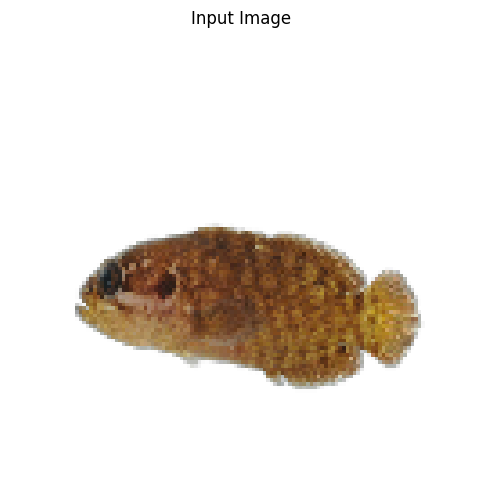

Top 3 Family Predictions:
Serranidae: 0.9927
Scorpaenidae: 0.0019
Blenniidae: 0.0017
Tetraodontidae: 0.0012
Gobiidae: 0.0010

Top 3 Genus Predictions:
Pseudogramma: 0.9966
Canthigaster: 0.0009
Fowleria: 0.0004
Scorpaenodes: 0.0004
Istigobius: 0.0003

Top 3 Species Predictions:
Pseudogramma polyacantha: 0.9946
Koumansetta rainfordi: 0.0007
Canthigaster solandri: 0.0005
Trimma macrophthalmus: 0.0005
Ucla xenogrammus: 0.0005


In [19]:
def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224,224) ,top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], image_size) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

idx = np.random.randint(0, test_df.shape[0])

image_path = test_df['image_path'].values[idx]

#image_path = '/Users/leonardo/Downloads/Screenshot 2025-01-08 at 7.37.07 PM.png'

print(f" Correct Prediction: {test_df['family'].values[idx]} {test_df['species'].values[idx]} \n")

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, names['family'], names['genus'], names['species'], top_k=5, image_size=(128, 128)
)


In [12]:
model.save(f'../models/{NICKNAME}.keras')

In [14]:
# Instantiate the class
ai = CryptoVisionAI(
    model_path=f'../models/{NICKNAME}.keras',
    family_names=names['family'],
    genus_names=names['genus'],
    species_names=names['species'],
)

/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'spatial_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [20]:
image_path = test_df['image_path'].values[idx]

pred = ai.predict(image_path, top_k=3)

print(f"""
      --- CryptoVisionAI Prediction ---
      \t Family: {pred[0]} ({ai.confidence[0]*100:.2f}%)
      \t Genus: {pred[1]} ({ai.confidence[1]*100:.2f}%)
      \t Species: {pred[2]} ({ai.confidence[2]*100:.2f}%)   
""")


      --- CryptoVisionAI Prediction ---
      	 Family: Serranidae (99.32%)
      	 Genus: Pseudogramma (99.66%)
      	 Species: Pseudogramma polyacantha (99.41%)   



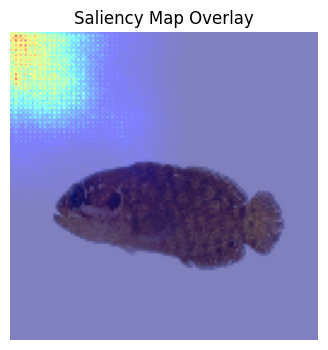

In [24]:
slcy_map = ai.generate_saliency_map('family', smooth_noise= .2, smooth_samples=100)
ai.plot_saliency_overlay(slcy_map, figure_size=(5,4))

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


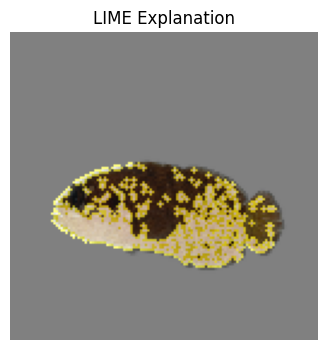

In [23]:
lime_map = ai.generate_lime_explanation(top_labels=1)
ai.plot_lime_results(lime_map, num_features=3, figure_size=(5,4))

### Old

In [15]:
pretrain = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
pretrain.trainable = False

inputs = Input(shape=image_shape, name='input')
x = efficientnet_preprocess(inputs)
x = pretrain(x, training=False)

features = GlobalAveragePooling2D()(x)

shared_layer = Dense(2048,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(shared_layer)

# Species Output
species_output = Dense(len(names['species']), activation='softmax', name='species')(shared_layer)

model_eff = tf.keras.Model(
    inputs, 
    [family_output, genus_output, species_output],
    name = "EfficientNetWithSharedSimple"
)

model_eff.summary()

Model: "EfficientNetWithSharedSimple"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 348, 348,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 11, 11,    │  5,919,312 │ input[0][0]       │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_layer        │ (None, 2048)      │  2,623,488 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ shared_layer[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 2048)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │     36,882 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 43)        │     88,107 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 61)        │    124,989 │ activation_4[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,800,970 (33.57 MB)

 Trainable params: 2,877,562 (10.98 MB)

 Non-trainable params: 5,923,408 (22.60 MB)

In [17]:
from cryptovision.model import TQDMProgressBar
import datetime

# Define TensorBoard log directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", ],
        'genus': ["accuracy", ],
        'species': ["accuracy", ],
    },
)

history = model_eff.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - family_accuracy: 0.4745 - family_loss: 0.3568 - genus_accuracy: 0.3430 - genus_loss: 0.6121 - loss: 1.6980 - species_accuracy: 0.2889 - species_loss: 0.7281 - val_family_accuracy: 0.8118 - val_family_loss: 0.2697 - val_genus_accuracy: 0.7839 - val_genus_loss: 0.4618 - val_loss: 1.3086 - val_species_accuracy: 0.7513 - val_species_loss: 0.5767
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - family_accuracy: 0.8624 - family_loss: 0.0704 - genus_accuracy: 0.8348 - genus_loss: 0.1216 - loss: 0.3635 - species_accuracy: 0.7890 - species_loss: 0.1713 - val_family_accuracy: 0.8822 - val_family_loss: 0.1264 - val_genus_accuracy: 0.8747 - val_genus_loss: 0.2270 - val_loss: 0.6542 - val_species_accuracy: 0.8392 - val_species_loss: 0.3005
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - family_accuracy: 0.9041 - family_loss: 0.0449 - genus_accuracy: 0.8952 - genus_loss: 0.0695 - loss: 0.2090 - species_accuracy: 0.8738 - species_loss: 0.0

In [18]:
results = model_eff.evaluate(test_ds, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - family_accuracy: 0.9368 - family_loss: 0.0263 - genus_accuracy: 0.9222 - genus_loss: 0.0409 - loss: 0.1167 - species_accuracy: 0.9181 - species_loss: 0.0499


In [21]:
for k, v in results.items():
    print(f" Testing {k}: {v:.3f}")

 Testing family_accuracy: 0.939
 Testing family_loss: 0.027
 Testing genus_accuracy: 0.925
 Testing genus_loss: 0.041
 Testing loss: 0.117
 Testing species_accuracy: 0.917
 Testing species_loss: 0.050


In [25]:
# Reproduction phorcys_v09

pretrain = ResNet50V2(include_top=False, weights='imagenet', input_shape=image_shape)
pretrain.trainable = False

augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(0.1, 0.1),
        RandomContrast(0.2),
        RandomBrightness(0.2),
    ],
    name='data_augmentation'
)

inputs = Input(shape=image_shape, name='input')
x = augmentation(inputs)
x = resnet_preprocess(x)
x = pretrain(x, training=False)
features = GlobalAveragePooling2D()(x)

shared_layer = Dense(512,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)
shared_layer = Dropout(0.3)(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_features = Concatenate()([shared_layer, family_output])
genus_hidden = Dense(256, activation='relu')(genus_features)
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(genus_hidden)

# Species Output
species_features = Concatenate()([shared_layer, family_output, genus_output])
species_hidden = Dense(256, activation='relu')(species_features)
species_output = Dense(len(names['species']), activation='softmax', name='species')(species_hidden)

model = tf.keras.Model(
    inputs, 
    [family_output, genus_output, species_output],
    name = "PhorcysV9"
)

model.summary()

Model: "PhorcysV9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 348, 348,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_10 (Cast)      │ (None, 348, 348,  │          0 │ input[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 348, 348,  │          0 │ cast_10[0][0]     │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_2       │ (None, 348, 348,  │          0 │ data_augmentatio… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 348, 348,  │          0 │ true_divide_2[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 11, 11,    │ 23,564,800 │ subtract_2[0][0]  │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_layer        │ (None, 512)       │  1,049,088 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ shared_layer[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │      9,234 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 530)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ family[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    135,936 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 43)        │     11,051 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 573)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ family[0][0],     │
│                     │                   │            │ genus[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    146,944 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 61)        │     15,677 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 24,934,778 (95.12 MB)

 Trainable params: 1,368,954 (5.22 MB)

 Non-trainable params: 23,565,824 (89.90 MB)

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = 'categorical_focal_crossentropy',
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
    loss_weights={
        "family": 1.0,
        "genus": 1.5,
        "species": 2.0,
    }
)

history_phorcys = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    verbose = 1,
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - family_AUC: 0.5811 - family_Precision: 0.3944 - family_Recall: 0.0266 - family_accuracy: 0.1473 - family_loss: 0.7071 - genus_AUC: 0.6374 - genus_Precision: 0.4784 - genus_Recall: 0.0083 - genus_accuracy: 0.1172 - genus_loss: 1.2813 - loss: 3.9124 - species_AUC: 0.6188 - species_Precision: 0.4756 - species_Recall: 0.0015 - species_accuracy: 0.0877 - species_loss: 1.9234 - val_family_AUC: 0.9324 - val_family_Precision: 0.9415 - val_family_Recall: 0.0704 - val_family_accuracy: 0.5798 - val_family_loss: 0.3101 - val_genus_AUC: 0.8982 - val_genus_Precision: 0.8500 - val_genus_Recall: 0.0068 - val_genus_accuracy: 0.4644 - val_genus_loss: 0.8419 - val_loss: 2.5535 - val_species_AUC: 0.8780 - val_species_Precision: 1.0000 - val_species_Recall: 0.0040 - val_species_accuracy: 0.3800 - val_species_loss: 1.4004
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - family_AUC: 0.9266 - family_Precision: 0.8476 - family_Recall: 0.2778 - family_acc

In [27]:
results_phorcys = model.evaluate(test_ds, return_dict=True)


20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - family_AUC: 0.9932 - family_Precision: 0.9345 - family_Recall: 0.7632 - family_accuracy: 0.8661 - family_loss: 0.0640 - genus_AUC: 0.9947 - genus_Precision: 0.9422 - genus_Recall: 0.7705 - genus_accuracy: 0.8675 - genus_loss: 0.1195 - loss: 0.3841 - species_AUC: 0.9943 - species_Precision: 0.9268 - species_Recall: 0.7044 - species_accuracy: 0.8338 - species_loss: 0.2036
 Testing family_accuracy: 0.939
 Testing family_loss: 0.027
 Testing genus_accuracy: 0.925
 Testing genus_loss: 0.041
 Testing loss: 0.117
 Testing species_accuracy: 0.917
 Testing species_loss: 0.050


In [28]:

for k, v in results_phorcys.items():
    print(f" Testing {k}: {v:.3f}")

 Testing family_AUC: 0.994
 Testing family_Precision: 0.940
 Testing family_Recall: 0.778
 Testing family_accuracy: 0.875
 Testing family_loss: 0.061
 Testing genus_AUC: 0.994
 Testing genus_Precision: 0.949
 Testing genus_Recall: 0.778
 Testing genus_accuracy: 0.865
 Testing genus_loss: 0.120
 Testing loss: 0.380
 Testing species_AUC: 0.995
 Testing species_Precision: 0.933
 Testing species_Recall: 0.719
 Testing species_accuracy: 0.835
 Testing species_loss: 0.201


In [29]:
model.summary(show_trainable=True)

Model: "PhorcysV9"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input             │ (None, 348,     │         0 │ -              │   -   │
│ (InputLayer)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast_10 (Cast)    │ (None, 348,     │         0 │ input[0][0]    │   -   │
│                   │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ data_augmentation │ (None, 348,     │         0 │ cast_10[0][0]  │   -   │
│ (Sequential)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ true_divide_2     │ (None, 348,     │         0 │ data_augmenta… │   -   │
│ (TrueDivide)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ subtract_2        │ (None, 348,     │         0 │ true_divide_2… │   -   │
│ (Subtract)        │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resnet50v2        │ (None, 11, 11,  │ 23,564,8… │ subtract_2[0]… │   N   │
│ (Functional)      │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ global_average_p… │ (None, 2048)    │         0 │ resnet50v2[0]… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ shared_layer      │ (None, 512)     │ 1,049,088 │ global_averag… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 512)     │     2,048 │ shared_layer[… │   Y   │
│ (BatchNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_7      │ (None, 512)     │         0 │ batch_normali… │   -   │
│ (Activation)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_2         │ (None, 512)     │         0 │ activation_7[… │   -   │
│ (Dropout)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ family (Dense)    │ (None, 18)      │     9,234 │ dropout_2[0][… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_3     │ (None, 530)     │         0 │ dropout_2[0][… │   -   │
│ (Concatenate)     │                 │           │ family[0][0]   │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_3 (Dense)   │ (None, 256)     │   135,936 │ concatenate_3… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ genus (Dense)     │ (None, 43)      │    11,051 │ dense_3[0][0]  │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_4     │ (None, 573)     │         0 │ dropout_2[0][… │   -   │
│ (Concatenate)     │                 │           │ family[0][0],  │       │
│                   │                 │           │ genus[0][0]    │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_4 (Dense)   │ (None, 256)     │   146,944 │ concatenate_4… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ species (Dense)   │ (None, 61)      │    15,677 │ dense_4[0][0]  │   Y 

 Total params: 27,672,692 (105.56 MB)

 Trainable params: 1,368,954 (5.22 MB)

 Non-trainable params: 23,565,824 (89.90 MB)

 Optimizer params: 2,737,914 (10.44 MB)

In [32]:
model.layers[2].trainable = True
for layer in model.layers[2].layers[:-90]:
    layer.trainable = False
    
model.summary(show_trainable=True)

Model: "PhorcysV9"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input             │ (None, 348,     │         0 │ -              │   -   │
│ (InputLayer)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast_10 (Cast)    │ (None, 348,     │         0 │ input[0][0]    │   -   │
│                   │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ data_augmentation │ (None, 348,     │         0 │ cast_10[0][0]  │   -   │
│ (Sequential)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ true_divide_2     │ (None, 348,     │         0 │ data_augmenta… │   -   │
│ (TrueDivide)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ subtract_2        │ (None, 348,     │         0 │ true_divide_2… │   -   │
│ (Subtract)        │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resnet50v2        │ (None, 11, 11,  │ 23,564,8… │ subtract_2[0]… │   Y   │
│ (Functional)      │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ global_average_p… │ (None, 2048)    │         0 │ resnet50v2[0]… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ shared_layer      │ (None, 512)     │ 1,049,088 │ global_averag… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 512)     │     2,048 │ shared_layer[… │   Y   │
│ (BatchNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_7      │ (None, 512)     │         0 │ batch_normali… │   -   │
│ (Activation)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_2         │ (None, 512)     │         0 │ activation_7[… │   -   │
│ (Dropout)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ family (Dense)    │ (None, 18)      │     9,234 │ dropout_2[0][… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_3     │ (None, 530)     │         0 │ dropout_2[0][… │   -   │
│ (Concatenate)     │                 │           │ family[0][0]   │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_3 (Dense)   │ (None, 256)     │   135,936 │ concatenate_3… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ genus (Dense)     │ (None, 43)      │    11,051 │ dense_3[0][0]  │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_4     │ (None, 573)     │         0 │ dropout_2[0][… │   -   │
│ (Concatenate)     │                 │           │ family[0][0],  │       │
│                   │                 │           │ genus[0][0]    │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_4 (Dense)   │ (None, 256)     │   146,944 │ concatenate_4… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ species (Dense)   │ (None, 61)      │    15,677 │ dense_4[0][0]  │   Y 

 Total params: 27,672,692 (105.56 MB)

 Trainable params: 21,928,826 (83.65 MB)

 Non-trainable params: 3,005,952 (11.47 MB)

 Optimizer params: 2,737,914 (10.44 MB)

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    loss = 'categorical_focal_crossentropy',
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
    loss_weights={
        "family": 1.0,
        "genus": 1.5,
        "species": 2.0,
    }
)

total_epochs = 15

history_phorcys_finetune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history_phorcys.epoch),
    validation_data=val_ds,
    verbose=1,
)

Epoch 11/15
13/92 ━━━━━━━━━━━━━━━━━━━━ 5:54 4s/step - family_AUC: 0.9783 - family_Precision: 0.8509 - family_Recall: 0.6048 - family_accuracy: 0.7355 - family_loss: 0.1314 - genus_AUC: 0.9858 - genus_Precision: 0.9268 - genus_Recall: 0.5798 - genus_accuracy: 0.7565 - genus_loss: 0.2347 - loss: 0.7413 - species_AUC: 0.9865 - species_Precision: 0.9042 - species_Recall: 0.5115 - species_accuracy: 0.7071 - species_loss: 0.3752

KeyboardInterrupt: 

In [3]:
from tensorflow.keras.layers import LayerNormalization